In [1]:
import mne
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
import deepFilter.dl_models as models
from keras import losses
import keras
from keras import backend as K
from enum import Enum
from typing import Dict, Callable, Union, Any
from keras.models import Sequential, Model
import numpy as np

In [2]:
# Custom loss SSD
def ssd_loss(y_true, y_pred):
    return K.sum(K.square(y_pred - y_true), axis=-2)

# Combined loss SSD + MSE
def combined_ssd_mse_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis=-2) * 500 + K.sum(K.square(y_true - y_pred), axis=-2)

def combined_ssd_mad_loss(y_true, y_pred):
    return K.max(K.square(y_true - y_pred), axis=-2) * 50 + K.sum(K.square(y_true - y_pred), axis=-2)

# Custom loss SAD
def sad_loss(y_true, y_pred):
    return K.sum(K.sqrt(K.square(y_pred - y_true)), axis=-2)

# Custom loss MAD
def mad_loss(y_true, y_pred):
    return K.max(K.square(y_pred - y_true), axis=-2)

In [3]:
class Experiment(Enum):
    FCN_DAE = 'FCN_DAE'
    DRNN = 'DRNN'
    Vanilla_L = 'Vanilla_L'
    Vanilla_NL = 'Vanilla_NL'
    Multibranch_LANL = 'Multibranch_LANL'
    Multibranch_LANLD = 'Multibranch_LANLD'

signal_size = 512

experiment_to_model: Dict[Experiment, Union[Model,Sequential]] = {
    Experiment.FCN_DAE: models.FCN_DAE(signal_size=signal_size),
    Experiment.DRNN: models.DRRN_denoising(signal_size=signal_size),
    Experiment.Vanilla_L: models.deep_filter_vanilla_linear(signal_size=signal_size),
    Experiment.Vanilla_NL: models.deep_filter_vanilla_Nlinear(signal_size=signal_size),
    Experiment.Multibranch_LANL: models.deep_filter_I_LANL(signal_size=signal_size),
    Experiment.Multibranch_LANLD: models.deep_filter_model_I_LANL_dilated(signal_size=signal_size)
}

experiment_to_loss: Dict[Experiment, Union[str, Callable[[np.ndarray,np.ndarray], Any]]] = {
    Experiment.DRNN: 'mse',
    Experiment.FCN_DAE: ssd_loss,
    Experiment.Vanilla_L: combined_ssd_mad_loss,
    Experiment.Vanilla_NL: combined_ssd_mad_loss,
    Experiment.Multibranch_LANL: combined_ssd_mad_loss,
    Experiment.Multibranch_LANLD: combined_ssd_mad_loss
}

2022-07-21 23:01:37.811365: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 23:01:37.835375: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 23:01:37.835474: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 23:01:37.836005: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [4]:
nv: int = 1

X_train: np.ndarray
y_train: np.ndarray
X_val: np.ndarray
y_val: np.ndarray
X_test: np.ndarray
y_test: np.ndarray

with open(f'data/dataset_nv{nv}.pkl', 'rb') as input:
    [X_train, y_train, X_test, y_test] = pickle.load(input)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, shuffle=True, random_state=1)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(50401, 512, 1) (21601, 512, 1) (13316, 512, 1)
(50401, 512, 1) (21601, 512, 1) (13316, 512, 1)


In [17]:
experiment = Experiment.DRNN

model = experiment_to_model[experiment]

model.compile(loss=experiment_to_loss[experiment],
    optimizer=keras.optimizers.Adam(lr=0.01),
    metrics=[losses.mean_squared_error, losses.mean_absolute_error, ssd_loss, mad_loss])

model.load_weights(f'./noise_version_{nv}/{experiment.value}_weights.best.hdf5')

y_pred: np.ndarray = model.predict(X_test, batch_size=32, verbose=1)

/home/panayiotis/Desktop/DeepFilter/.venv/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


417/417 [==============================] - 2s 5ms/step


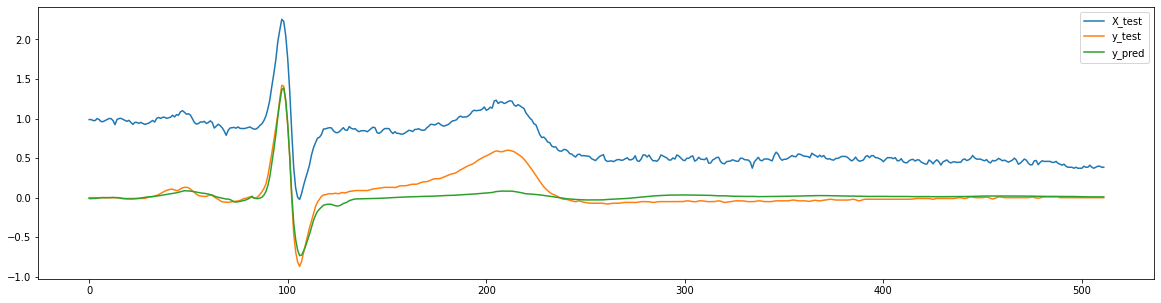

In [18]:
plt.figure(figsize=(20,5))
plt.plot(X_test[0], label='X_test')
plt.plot(y_test[0], label='y_test')
plt.plot(y_pred[0], label='y_pred')
plt.legend()
plt.show()

In [19]:
# load data
def load_data(data):
    data = mne.io.read_raw_edf(data)
    info = data.info
    raw_ecg = data.get_data()
    return raw_ecg, info

In [20]:
signal_path = '/shared/Delineation Dataset/AttCHR0102rcs4_Sinius/13-20-54.EDF'

raw_ecg, info = load_data(signal_path)
# Get only the 1st channel that contains the raw ecg data
raw = raw_ecg[0]

Extracting EDF parameters from /shared/Delineation Dataset/AttCHR0102rcs4_Sinius/13-20-54.EDF...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [21]:
raw.shape

(22674500,)

In [22]:
info

<Info | 7 non-empty values
 bads: []
 ch_names: ECG, Marker, HRV, DEV_vbat
 chs: 4 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: 2022-01-31 13:20:54 UTC
 nchan: 4
 projs: []
 sfreq: 250.0 Hz
>

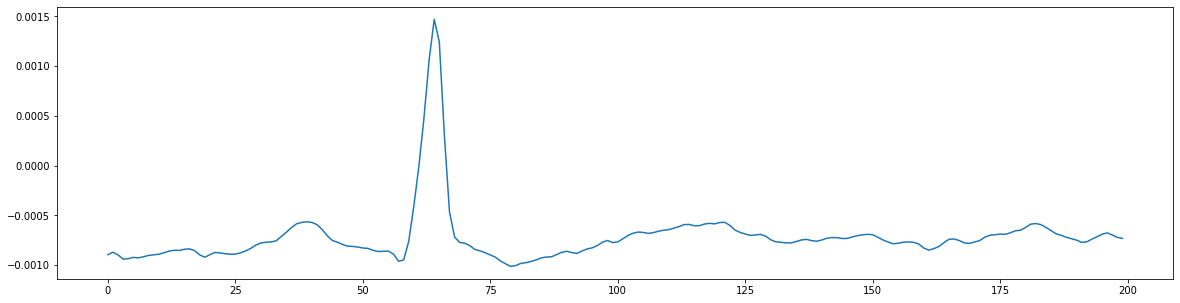

In [29]:
plt.figure(figsize=(20,5))
plt.plot(raw[7_470:7_670])
plt.show()

In [ ]:
# scipy resampling
# notebook in browser for better plots %matplotlib qt